In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import models
from torchvision import datasets
import torchvision

In [64]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [65]:

#load data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)

# split data
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset)*0.7), int(len(train_dataset)*0.3)])

# create data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
device = torch.device('mps')
device

device(type='mps')

minibatch size:  64
image shape:  3 32 32
label shape:  64
tensor([7, 9, 8, 3, 1, 1, 3, 4, 4, 7, 2, 6, 7, 7, 5, 5, 0, 4, 4, 3, 9, 7, 6, 7,
        4, 2, 8, 9, 9, 4, 4, 9, 4, 8, 0, 3, 9, 4, 6, 7, 2, 4, 4, 0, 9, 0, 7, 8,
        0, 9, 4, 6, 2, 9, 2, 0, 5, 9, 3, 1, 2, 6, 8, 1])
3


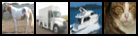

In [67]:
# check the images that I will use for this experiment
images, labels = next(iter(train_loader))
c, h, w = images[0].shape
print("minibatch size: ", len(images))
print("image shape: ", c, h, w)
print("label shape: ", len(labels))

# check the label
print(labels)
print(c)

# check the image
img = torchvision.utils.make_grid(images[:4])
img = transforms.functional.to_pil_image(img)
display(img)


In [68]:
input_size = 28*28
output_size = 10

In [69]:
model = nn.Sequential(
    # 1つ目の畳み込みブロック
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 出力: 64x16x16
    nn.Dropout2d(0.25),
    
    # 2つ目の畳み込みブロック
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 出力: 128x8x8
    nn.Dropout2d(0.25),
    
    # 3つ目の畳み込みブロック
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 出力: 256x4x4
    nn.Dropout2d(0.25),
    
    nn.Flatten(),
    
    # 全結合層
    nn.Linear(256 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(128, output_size)
)
model = model.to(device)



In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [71]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Validation Accuracy: {100 * correct / total}%")

Epoch 1/10, Loss: 1.877103567123413
Validation Accuracy: 40.22%
Epoch 2/10, Loss: 1.528976321220398
Validation Accuracy: 46.39333333333333%
Epoch 3/10, Loss: 1.1595208644866943
Validation Accuracy: 60.093333333333334%
Epoch 4/10, Loss: 1.181916356086731
Validation Accuracy: 59.1%
Epoch 5/10, Loss: 1.1204421520233154
Validation Accuracy: 65.59333333333333%
Epoch 6/10, Loss: 1.2635897397994995
Validation Accuracy: 69.41333333333333%
Epoch 7/10, Loss: 0.9928188920021057
Validation Accuracy: 71.16%
Epoch 8/10, Loss: 1.0490210056304932
Validation Accuracy: 73.82666666666667%
Epoch 9/10, Loss: 0.8357630968093872
Validation Accuracy: 74.7%
Epoch 10/10, Loss: 0.8985664248466492
Validation Accuracy: 76.5%
